In [1]:
import os
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.utils as ut
import mitequinox.plot as pl

In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(walltime='06:00:00')
    w = cluster.scale(jobs=20)
    client = Client(cluster)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35864 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 100.00 GiB


## Store

In [ ]:
# same but over all variables and faces
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
#V = V+["KPPhbl", "qsoceTAUX", "oceTAUY"]

In [ ]:
def compute_store(v, ds, diag, op):
    #i, j = ut.get_ij_dims(ds)
    diag_zarr = diag+"_"+v
    if not ut.is_diagnostic(diag_zarr):
        out, tmp_zarr = ut.custom_distribute(ds, op, 
                                             tmp_dir=ut.scratch+"tmp/", 
                                             face=1, ) # **{j: 1080}
        ut.store_diagnostic(diag_zarr, out, overwrite=True)
        print("{} {} stored".format(v, diag))
    else:
        print("{} {} already exists".format(v, diag))

In [ ]:
diags = {"mean": lambda x: x.mean("time"),
         "mean_square": lambda x: (x**2).mean("time"),
        }
        
for v in V:
    ds = ut.load_data(v)
    for diag, op in diags.items():
        compute_store(v, ds, diag, op)

# Read results

In [111]:
# load diagnostics
#V = ["SSU","SSV"]
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean", "mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])#.rename({'i_g': 'i'})#.rename({'j_g': 'j'})

grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
ds = ds.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080)
Coordinates: (12/20)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * i_g              (i_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
  * j_g              (j_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    ...               ...
    dyC              (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG              (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA               (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rAs              (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rAw              (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rAz              (face, j_g, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    mean_Eta         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_Eta  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SSU         (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SSU  (face, j, i_g) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SSV         (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SSV  (face, j_g, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SST         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SST  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_SSS         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mean_square_SSS  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lon              (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lat              (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

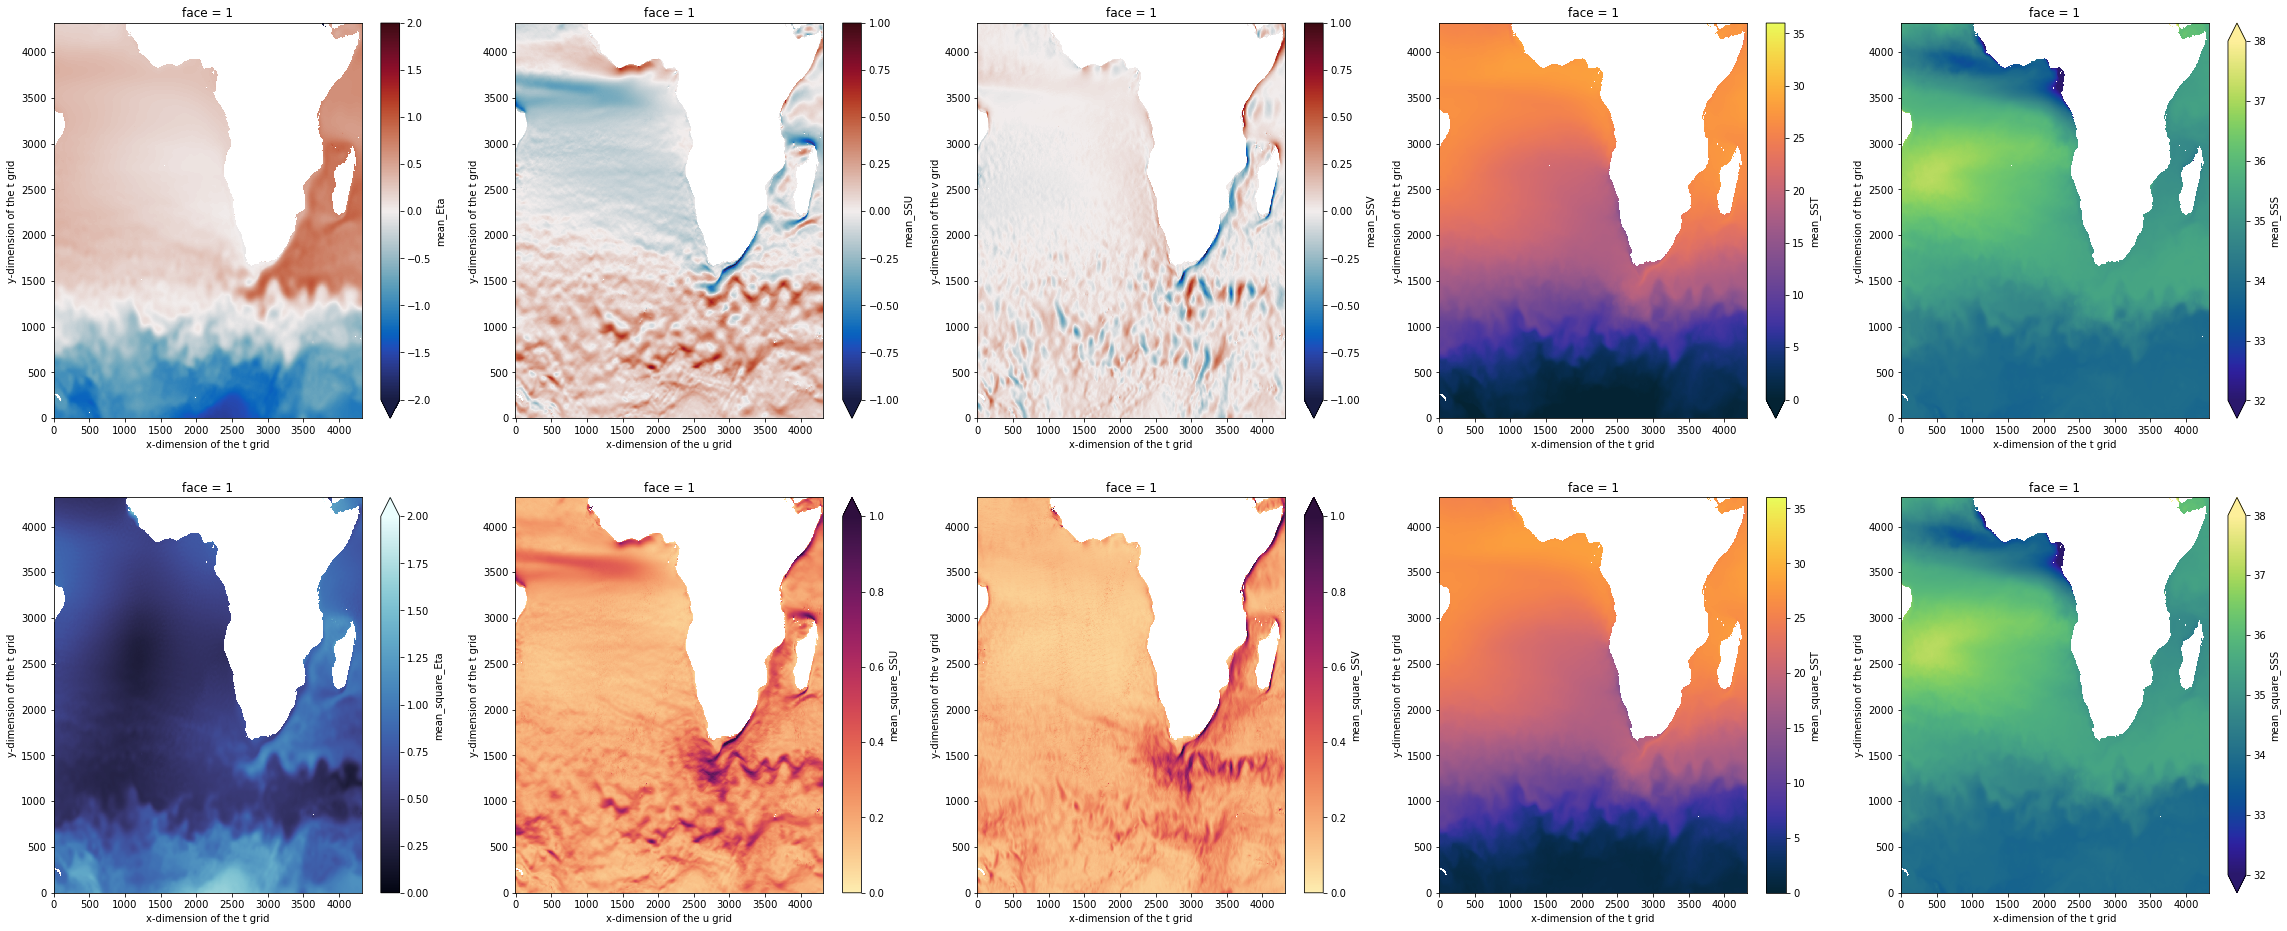

In [76]:
fig, ax = plt.subplots(figsize=(40,16))

ax = plt.subplot(251)
ds.mean_Eta.isel(face=1).plot(vmin=-2,vmax=2,cmap=cm.balance)

ax = plt.subplot(252)
ds.mean_SSU.isel(face=1).plot(vmin=-1,vmax=1,cmap=cm.balance)

ax = plt.subplot(253)
ds.mean_SSV.isel(face=1).plot(vmin=-1,vmax=1,cmap=cm.balance)

ax = plt.subplot(254)
ds.mean_SST.isel(face=1).plot(vmin=0,vmax=36,cmap=cm.thermal)

ax = plt.subplot(255)
ds.mean_SSS.isel(face=1).plot(vmin=32,vmax=38,cmap=cm.haline)

ax = plt.subplot(256)
np.sqrt(ds.mean_square_Eta.isel(face=1)).plot(vmin=0,vmax=2,cmap=cm.ice)

ax = plt.subplot(257)
np.sqrt(ds.mean_square_SSU.isel(face=1)).plot(vmin=0,vmax=1,cmap=cm.matter)

ax = plt.subplot(258)
np.sqrt(ds.mean_square_SSV.isel(face=1)).plot(vmin=0,vmax=1,cmap=cm.matter)

ax = plt.subplot(259)
np.sqrt(ds.mean_square_SST.isel(face=1)).plot(vmin=0,vmax=36,cmap=cm.thermal)

ax = plt.subplot(2,5,10)
np.sqrt(ds.mean_square_SSS.isel(face=1)).plot(vmin=32,vmax=38,cmap=cm.haline)

In [112]:
ds.load()

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080)
Coordinates: (12/20)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * i_g              (i_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
  * j_g              (j_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...               ...
    dyC              (face, j_g, i) float32 239.5 239.5 239.6 ... 324.6 324.6
    dyG              (face, j, i_g) float32 479.0 479.1 479.2 ... 324.6 324.6
    rA               (face, j, i) float32 1.555e+05 1.555e+05 ... 1.556e+05
    rAs              (face, j_g, i) float32 7.774e+04 7.776e+04 ... 1.556e+05
    rAw              (face, j, i_g) float32 1.555e+05 1.555e+05 ... 1.556e+05
    rAz              (face, j_g, i_g) float32 7.774e+04 7.776e+04 ... 1.556e+05
Data variables:
    mean_Eta         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_Eta  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SSU         (face, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSU  (face, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    mean_SSV         (face, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSV  (face, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SST         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SST  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SSS         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSS  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    lon              (face, j, i) float64 -114.9 -114.9 -114.9 ... -114.0 -114.5
    lat              (face, j, i) float64 -88.18 -88.19 -88.2 ... -88.17 -88.17

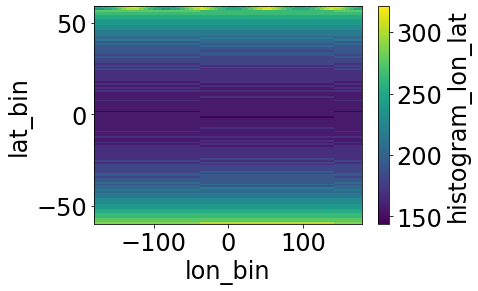

In [114]:
#dl = 0.1
dl = 1

lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60., 60., dl)

N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), bins=[lon_bins, lat_bins], dim=['i', 'j', 'face'], block_size=None)
N.plot(x='lon_bin',y='lat_bin')

In [115]:
E_KE = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
                 bins=[lon_bins, lat_bins], 
                 weights= (ds.mean_square_SSU.rename({'i_g': 'i'}) + ds.mean_square_SSV.rename({'j_g': 'j'})), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

In [116]:
E_Eta = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
                  bins=[lon_bins, lat_bins], 
                  weights= ds.mean_Eta, 
                  dim=['i', 'j','face'],
                  block_size=None
                 )

In [117]:
E_SST = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
                  bins=[lon_bins, lat_bins], 
                  weights= ds.mean_SST, 
                  dim=['i', 'j','face'],
                  block_size=None
                 )

In [118]:
E_SSS = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
                  bins=[lon_bins, lat_bins], 
                  weights= ds.mean_SSS, 
                  dim=['i', 'j','face'],
                  block_size=None
                 )

In [121]:
E_SSU = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
                  bins=[lon_bins, lat_bins], 
                  weights= ds.mean_SSU.rename({'i_g': 'i'}), 
                  dim=['i', 'j','face'],
                  block_size=None
                 )

In [123]:
E_SSV = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
                  bins=[lon_bins, lat_bins], 
                  weights= ds.mean_SSV.rename({'j_g': 'j'}), 
                  dim=['i', 'j','face'],
                  block_size=None
                 )

Text(0.5, 1.0, 'SSS')

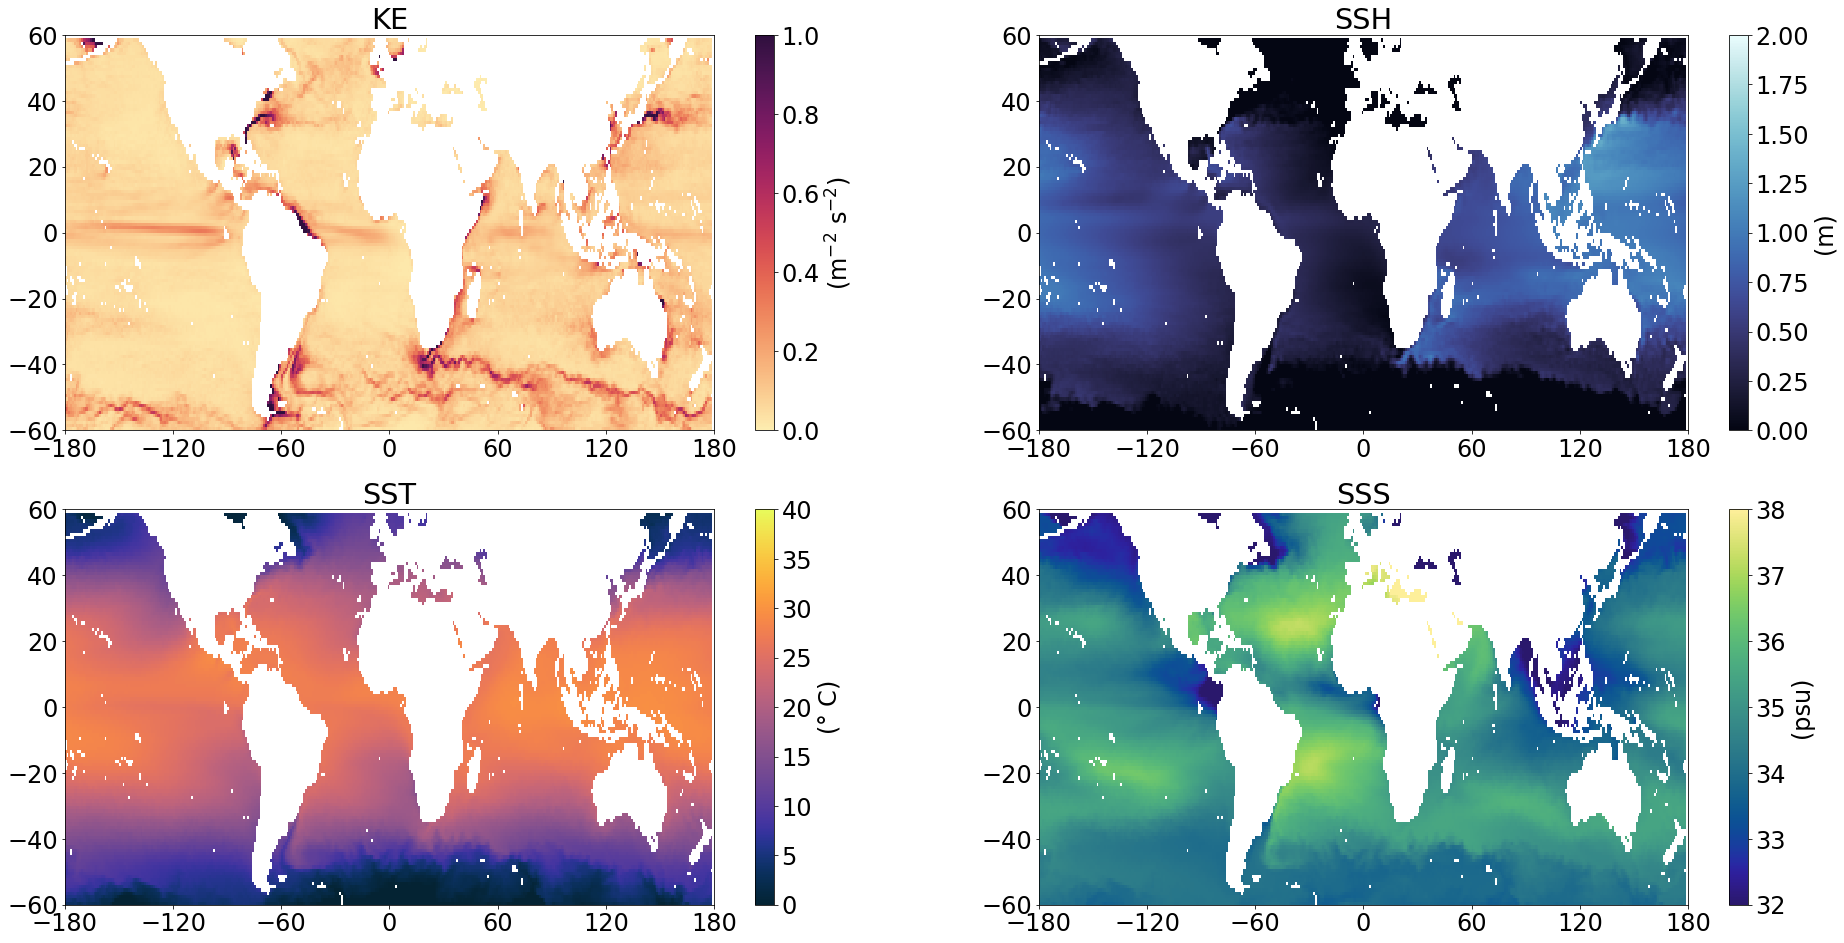

In [119]:
plt.rc('font', size=24) 
font_size=24


fig, ax = plt.subplots(figsize=(32,16))

ax = plt.subplot(221)
cax = (E_KE/N).plot(x='lon_bin',y='lat_bin',vmin=0,vmax=1,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('KE')

ax = plt.subplot(222)
cax = (E_Eta/N).plot(x='lon_bin',y='lat_bin',vmin=0,vmax=2,cmap=cm.ice, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSH')

ax = plt.subplot(223)
cax = (E_SST/N).plot(x='lon_bin',y='lat_bin',vmin=0,vmax=40,cmap=cm.thermal, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('($\degree$ C)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SST')

ax = plt.subplot(224)
cax = (E_SSS/N).plot(x='lon_bin',y='lat_bin',vmin=32,vmax=38,cmap=cm.haline, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(psu)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSS')

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Eulerian_mean_1degree.png')

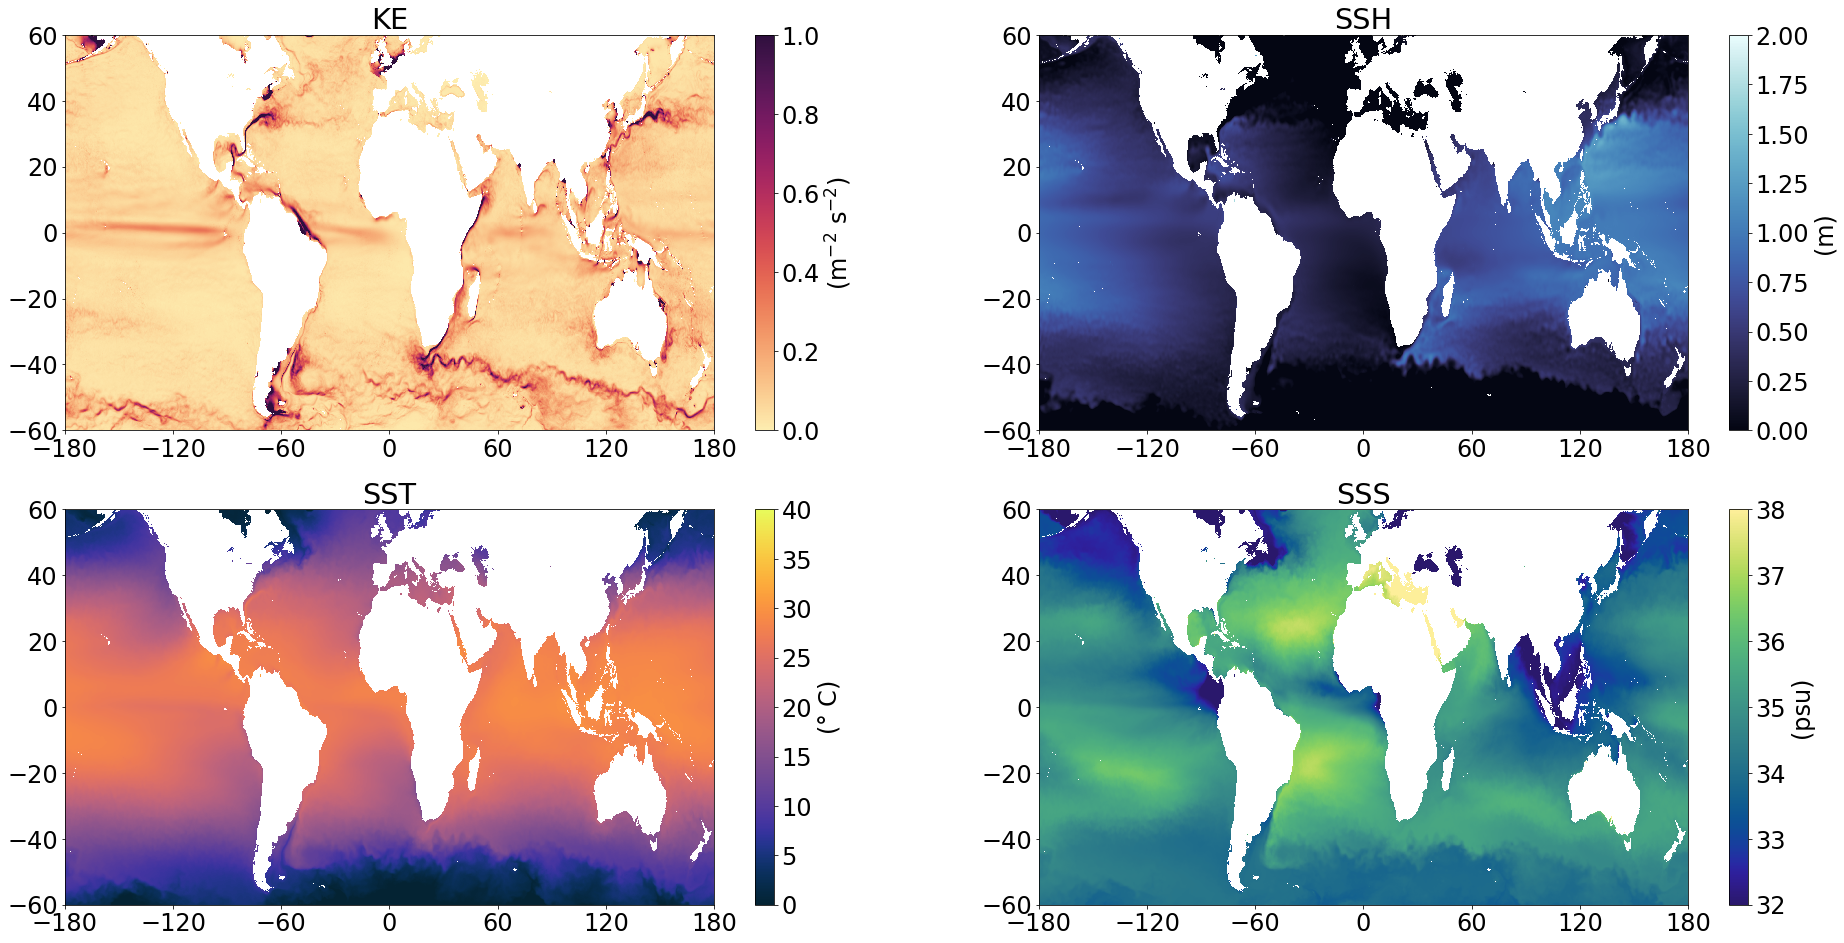

In [110]:
plt.rc('font', size=24) 
font_size=24


fig, ax = plt.subplots(figsize=(32,16))

ax = plt.subplot(221)
cax = (E_KE/N).plot(x='lon_bin',y='lat_bin',vmin=0,vmax=1,cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('KE')

ax = plt.subplot(222)
cax = (E_Eta/N).plot(x='lon_bin',y='lat_bin',vmin=0,vmax=2,cmap=cm.ice, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSH')

ax = plt.subplot(223)
cax = (E_SST/N).plot(x='lon_bin',y='lat_bin',vmin=0,vmax=40,cmap=cm.thermal, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('($\degree$ C)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SST')

ax = plt.subplot(224)
cax = (E_SSS/N).plot(x='lon_bin',y='lat_bin',vmin=32,vmax=38,cmap=cm.haline, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(psu)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSS')

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Eulerian_mean_01degree.png')

Text(0.5, 1.0, 'SSV')

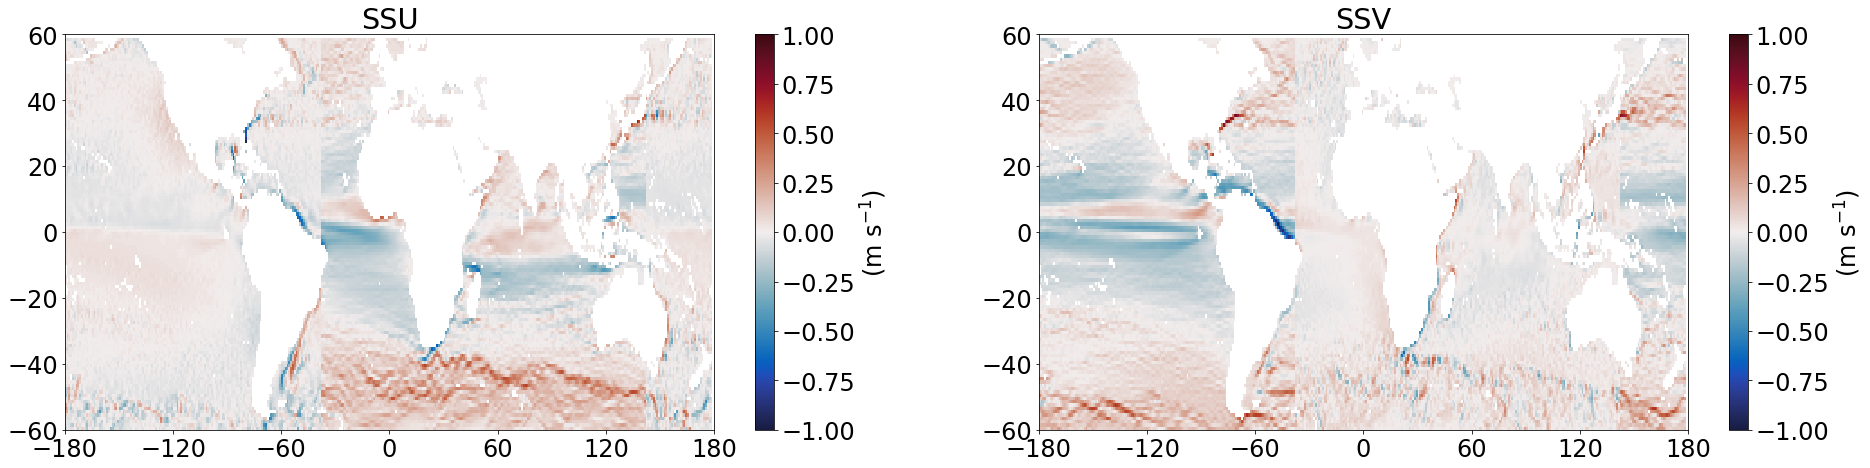

In [125]:
plt.rc('font', size=24) 
font_size=24


fig, ax = plt.subplots(figsize=(32,16))

ax = plt.subplot(221)
cax = (E_SSU/N).plot(x='lon_bin',y='lat_bin',vmin=-1,vmax=1,cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m s$^{-1}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSU')

ax = plt.subplot(222)
cax = (E_SSV/N).plot(x='lon_bin',y='lat_bin',vmin=-1,vmax=1,cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend=None, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m s$^{-1}$)', fontsize=font_size)
ax.set_xlim([-180,180])
ax.set_ylim([-60., 60.])
ax.set_xticks([-180, -120,-60, 0, 60, 120, 180])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('SSV')

In [77]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
